In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epochs = 18
plt.style.use('seaborn')


In [3]:
# download dataset
# !wget -O dataset.tar.gz https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget -O labels.tar.gz https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
class Cat_Dog_Dataset(Dataset):
    def __init__(self, label_dir, data_dir, train, transform=None):
        np.random.seed(0)
        self.label_dir = label_dir
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.filter_dataset()
        
    def class_vise_idx(self, labels, size):
        all_cats = labels[labels[:, 2] == '1']
        filtered_cats = all_cats[np.random.choice(len(all_cats), size=size, replace=False)]

        all_dogs = labels[labels[:, 2] == '2']
        filtered_dogs = all_dogs[np.random.choice(len(all_dogs), size=size, replace=False)]
        filtered_labels = np.vstack((filtered_cats, filtered_dogs))
        return np.delete(filtered_labels, [1, -1], axis=1)
        
    def filter_dataset(self):
        if self.train:
            label_path = os.path.join(self.label_dir, "trainval.txt")
            labels = np.loadtxt(label_path, dtype=object)
            self.labels = self.class_vise_idx(labels, size=600)

        else:
            label_path = os.path.join(self.label_dir, "test.txt")
            labels = np.loadtxt(label_path, dtype=object)
            self.labels = self.class_vise_idx(labels, size=400)
            
    def t_transform(self, label, n_classes=2):
        sample = torch.eye(n_classes, dtype=int)
        if label == 1:
            return sample[0]
        if label == 2:
            return sample[1]
        
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.labels)
    
    def visual(self, img):
        plt.imshow(img)
        plt.show
    
    def __getitem__(self, idx):
        name, label = self.labels[idx]
        file_path = os.path.join(self.data_dir, name+'.jpg')
        img = np.array(Image.open(file_path).convert('RGB'))
        
        if self.transform:
            img = self.t(img)

        label = self.t_transform(int(label))
        return (img, label)

In [5]:
label_dir = "./data/annotations"
data_dir = "./data/images"

t = transforms.Compose([transforms.ToTensor(),
                        transforms.ColorJitter(brightness=.5, hue=.3),
                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.Resize((224, 224)),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

train_dataset = Cat_Dog_Dataset(label_dir, data_dir, train=True, transform=t)
test_dataset = Cat_Dog_Dataset(label_dir, data_dir, train=False, transform=test_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

In [7]:
def train(model, train_loader, optimizer, criterion, epoch, allow_cutmix):
    """
    Training for one epoch
    """
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, (images, labels) in pbar:
        if allow_cutmix:
            images, labels = generate_cutmix_image(images, labels, 1.0)
        
        # put on gpu
        images, labels = images.to(device), labels.type(torch.float32).to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return loss_list, avg_loss

@torch.no_grad()
def testing(model, test_loader, criterion):
    """
    Testing the accuracy for validation set
    """
    model.eval()
    correct = 0
    loss_list = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.type(torch.float32).to(device)
        model = model.to(device)
        criterion = criterion.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        
        preds = torch.argmax(outputs, dim=1)
        gt = torch.argmax(labels, dim=1)
        
        loss_list.append(loss.item())
        correct += torch.count_nonzero(preds == gt)
    accuracy = correct / len(test_dataset)

    return accuracy, np.mean(loss_list)
        
def training_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, allow_cutmix):
    """
    Training and testing of model for N number of EPOCHS
    """
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "valid_acc": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
        # testing 
        acc, v_loss = testing(model, valid_loader, criterion)
        stats["valid_acc"].append(acc.item())
        stats["val_loss"].append(v_loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        epoch_loss_list, epoch_loss = train(model, train_loader, optimizer, criterion, epoch, allow_cutmix)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
            

        if epoch == 0 or (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            saving_model(model, optimizer, epoch, stats)
            print(f"Accuracy for epoch: {epoch+1} is ", stats["valid_acc"][-1])       

    print(f"Training completed")

In [8]:
# util functions 
def generate_cutmix_image(input, target, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    Ref: "https://www.kaggle.com/debanga/cutmix-in-python"
    """
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(input.size()[0])
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

    return input, target

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

## Memory allocation confusion

Okay so I saw that my model always remained on the GPU even tho I deleted the variable model from this function below and all the remaining refrences above at the commented locations. 

So I specifically had to move the model to cpu and then run the following (below) commands to free the GPU memory. Have no idea why

```
    gc.collect()
    torch.cuda.empty_cache()
    print("*" * 20)
    print(f"After del model after full_train end fn: {torch.cuda.memory_allocated()}")
```

In [9]:
def training_full_model(model, train_loader, valid_loader, num_epochs, allow_cutmix=True):
    LR = 3e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, allow_cutmix)

#     del model
#     print(next(model.parameters()).is_cuda)
    model = model.to("cpu")
#     print(next(model.parameters()).is_cuda)
    print("Memory Allocated before gc ", torch.cuda.memory_allocated())


### Chaning models last layer as per our needs
Since VGG, Resnet and DenseNet are all trained on ImageNet challange, the output layer for all  these models have 1000 units. Thus first we need to change it as per our need which is 2 classes

In [10]:
# Should be changed as well
def fixed_or_finetuned(model_name: str, fixed: bool, custom_name=None):
    assert model_name in ["vgg", "resnet", "dense"]
    if model_name == "vgg":
        model = models.vgg16(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
            for param in model.parameters():
                param.requires_grad = False
        if not fixed:
            model.name = f"{model_name}_finetuned"
        model.classifier = nn.Sequential(
                                nn.Linear(in_features=25088, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=1000),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features=1000, out_features=2))
    
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
            for param in model.parameters():
                param.requires_grad = False
        if not fixed: 
            model.name = f"{model_name}_finetuned"
        model.fc = nn.Sequential(
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 2))
    
    if model_name == "dense":
        model = models.densenet161(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
        if not fixed: 
            model.name = f"{model_name}_finetuned"
        model.classifier = nn.Sequential(
                                    nn.Linear(2208, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 2))
    if custom_name:
        model.name = custom_name
    return model

## Fine tuned VGG, ResNet and DenseNet  

In [12]:
resnet_finetuned = fixed_or_finetuned(model_name="resnet", fixed=False)
vgg_finetuned = fixed_or_finetuned(model_name="vgg", fixed=False)
dense_finetuned = fixed_or_finetuned(model_name="dense", fixed=False)

## Fine Tuned Models and Comparison

In [13]:
%time training_full_model(model=resnet_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.63356: 100%|████████████| 75/75 [00:15<00:00,  4.89it/s]

Accuracy for epoch: 1 is  0.45499998331069946



Epoch 3, Itr 75, Loss 0.74184: 100%|████████████| 75/75 [00:15<00:00,  4.89it/s]

Accuracy for epoch: 3 is  0.5837500095367432



Epoch 6, Itr 75, Loss 0.42271: 100%|████████████| 75/75 [00:17<00:00,  4.38it/s]


Accuracy for epoch: 6 is  0.7274999618530273


Epoch 9, Itr 75, Loss 0.42383: 100%|████████████| 75/75 [00:15<00:00,  4.77it/s]


Accuracy for epoch: 9 is  0.8974999785423279


Epoch 12, Itr 75, Loss 0.42606: 100%|███████████| 75/75 [00:15<00:00,  4.78it/s]

Accuracy for epoch: 12 is  0.9212499856948853



Epoch 15, Itr 75, Loss 0.49206: 100%|███████████| 75/75 [00:16<00:00,  4.44it/s]


Accuracy for epoch: 15 is  0.9174999594688416


Epoch 18, Itr 75, Loss 0.27613: 100%|███████████| 75/75 [00:15<00:00,  4.97it/s]


Accuracy for epoch: 18 is  0.9350000023841858
Training completed
Memory Allocated before gc  91423744
CPU times: user 2min 37s, sys: 10.2 s, total: 2min 47s
Wall time: 5min 14s


In [14]:
gc.collect()
torch.cuda.empty_cache()
print("Memory Allocated now ", torch.cuda.memory_allocated())


Memory Allocated now  0


In [15]:
%time training_full_model(model=dense_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.90072: 100%|████████████| 75/75 [00:28<00:00,  2.65it/s]


Accuracy for epoch: 1 is  0.6549999713897705


Epoch 3, Itr 75, Loss 0.60791: 100%|████████████| 75/75 [00:28<00:00,  2.64it/s]


Accuracy for epoch: 3 is  0.6637499928474426


Epoch 6, Itr 75, Loss 0.42123: 100%|████████████| 75/75 [00:28<00:00,  2.63it/s]


Accuracy for epoch: 6 is  0.7099999785423279


Epoch 9, Itr 75, Loss 0.43791: 100%|████████████| 75/75 [00:28<00:00,  2.64it/s]


Accuracy for epoch: 9 is  0.8762499690055847


Epoch 12, Itr 75, Loss 0.41619: 100%|███████████| 75/75 [00:28<00:00,  2.63it/s]


Accuracy for epoch: 12 is  0.8862499594688416


Epoch 15, Itr 75, Loss 0.25894: 100%|███████████| 75/75 [00:30<00:00,  2.50it/s]


Accuracy for epoch: 15 is  0.89124995470047


Epoch 18, Itr 75, Loss 0.62151: 100%|███████████| 75/75 [00:28<00:00,  2.62it/s]


Accuracy for epoch: 18 is  0.8962500095367432
Training completed
Memory Allocated before gc  224796672
CPU times: user 8min 7s, sys: 3min 5s, total: 11min 13s
Wall time: 10min 28s


In [18]:
gc.collect()
torch.cuda.empty_cache()
print("Memory Allocated now ", torch.cuda.memory_allocated())

Memory Allocated now  0


In [19]:
%time training_full_model(model=vgg_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.69860: 100%|████████████| 75/75 [00:20<00:00,  3.62it/s]


Accuracy for epoch: 1 is  0.4899999797344208


Epoch 3, Itr 75, Loss 0.69315: 100%|████████████| 75/75 [00:20<00:00,  3.63it/s]


Accuracy for epoch: 3 is  0.5


Epoch 6, Itr 75, Loss 0.69311: 100%|████████████| 75/75 [00:22<00:00,  3.39it/s]


Accuracy for epoch: 6 is  0.5


Epoch 9, Itr 75, Loss 0.69324: 100%|████████████| 75/75 [00:20<00:00,  3.59it/s]


Accuracy for epoch: 9 is  0.5


Epoch 12, Itr 75, Loss 0.68838: 100%|███████████| 75/75 [00:21<00:00,  3.53it/s]


Accuracy for epoch: 12 is  0.5


Epoch 15, Itr 75, Loss 0.69343: 100%|███████████| 75/75 [00:21<00:00,  3.50it/s]


Accuracy for epoch: 15 is  0.5


Epoch 18, Itr 75, Loss 0.69312: 100%|███████████| 75/75 [00:21<00:00,  3.54it/s]


Accuracy for epoch: 18 is  0.5
Training completed
Memory Allocated before gc  1108714496
CPU times: user 8min 12s, sys: 18.1 s, total: 8min 30s
Wall time: 7min 45s


## ResNet as Fixed Feature Extractor and Comparion with fine tuned ResNet

In [20]:
resnet_fixed = fixed_or_finetuned(model_name="resnet", fixed=True)

In [21]:
%time training_full_model(model=resnet_fixed, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.75163: 100%|████████████| 75/75 [00:15<00:00,  4.98it/s]

Accuracy for epoch: 1 is  0.2487500011920929



Epoch 3, Itr 75, Loss 0.69671: 100%|████████████| 75/75 [00:15<00:00,  4.92it/s]


Accuracy for epoch: 3 is  0.9162499904632568


Epoch 6, Itr 75, Loss 0.54402: 100%|████████████| 75/75 [00:15<00:00,  4.99it/s]


Accuracy for epoch: 6 is  0.8050000071525574


Epoch 9, Itr 75, Loss 0.54219: 100%|████████████| 75/75 [00:15<00:00,  4.93it/s]


Accuracy for epoch: 9 is  0.9375


Epoch 12, Itr 75, Loss 0.45477: 100%|███████████| 75/75 [00:15<00:00,  4.88it/s]


Accuracy for epoch: 12 is  0.9387499690055847


Epoch 15, Itr 75, Loss 0.40311: 100%|███████████| 75/75 [00:15<00:00,  4.94it/s]


Accuracy for epoch: 15 is  0.9350000023841858


Epoch 18, Itr 75, Loss 0.79513: 100%|███████████| 75/75 [00:15<00:00,  4.69it/s]


Accuracy for epoch: 18 is  0.9375
Training completed
Memory Allocated before gc  1055744
CPU times: user 1min 49s, sys: 10.8 s, total: 2min
Wall time: 5min 7s


### Loading models from disk

In [22]:
# model definition
resnet_epoch_18 = fixed_or_finetuned(model_name="resnet", fixed=False)
dense_epoch_18 = fixed_or_finetuned(model_name="dense", fixed=False)
vgg_epoch_18 = fixed_or_finetuned(model_name="vgg", fixed=False)
resnet_fixed_epoch_18 = fixed_or_finetuned(model_name="resnet", fixed=True)

#loading models
resnet_epoch_18, _, _, stats_resnet_finetuned = loading_model(resnet_epoch_18, "models/resnet_finetuned_18.pth")
dense_epoch_18, _, _, stats_dense_finetuned = loading_model(dense_epoch_18, "models/dense_finetuned_18.pth")
vgg_epoch_18, _, _, stats_vgg_finetuned = loading_model(vgg_epoch_18, "models/vgg_finetuned_18.pth")
resnet_fixed_epoch_18, _, _, stats_resnet_fixed_epoch18 = loading_model(resnet_fixed_epoch_18, "models/resnet_fixed_18.pth")

## Comparison Plots for various models

### a) Fine Tuned VGG, ResNet and DenseNet
Below are the comparisons for all the fine tuned models

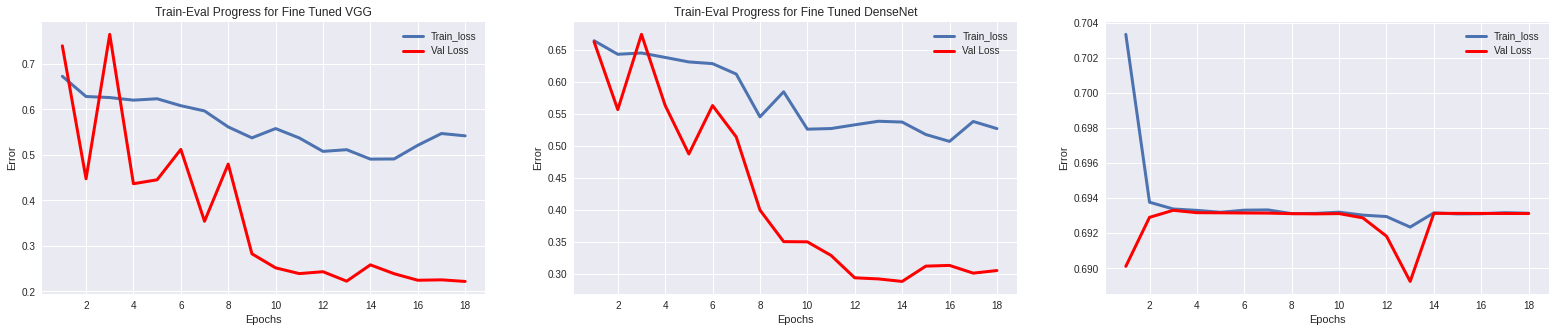

In [23]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(27, 5)

ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Train-Eval Progress for Fine Tuned DenseNet")

ax[2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[2].legend(loc='best')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Error")
ax[2].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned VGG")


plt.show()

### b) Fixed backbone ResNet v/s Fine Tuned ResNet

Below is the comparison

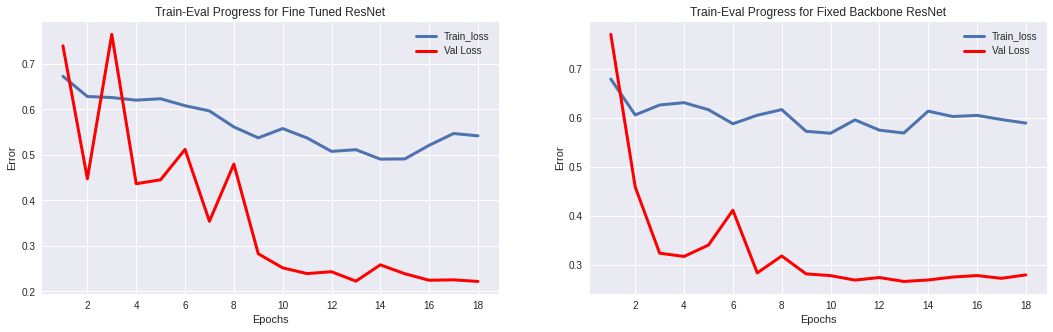

In [24]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[1].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['train_loss'], label="Train_loss", linewidth=3)
ax[1].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Train-Eval Progress for Fixed Backbone ResNet")
plt.show()

## Experimental

So now we see that the val loss is much lower than the training loss. The suspected reason for this is the heavy regularization (CutMix) that we applied in the training and not in the testing scenerio. 

So lets prove this reasoning by training another ResNet model without CutMix.

In [25]:
resnet_no_cutmix = fixed_or_finetuned(model_name="resnet", fixed=False, custom_name="exp_resnet")
%time training_full_model(model=resnet_no_cutmix, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs, allow_cutmix=False)

Epoch 1, Itr 75, Loss 0.38963: 100%|████████████| 75/75 [00:15<00:00,  4.92it/s]


Accuracy for epoch: 1 is  0.53125


Epoch 3, Itr 75, Loss 0.32552: 100%|████████████| 75/75 [00:15<00:00,  4.81it/s]


Accuracy for epoch: 3 is  0.887499988079071


Epoch 6, Itr 75, Loss 0.74188: 100%|████████████| 75/75 [00:15<00:00,  5.00it/s]


Accuracy for epoch: 6 is  0.9249999523162842


Epoch 9, Itr 75, Loss 0.03236: 100%|████████████| 75/75 [00:15<00:00,  4.84it/s]


Accuracy for epoch: 9 is  0.9599999785423279


Epoch 12, Itr 75, Loss 0.02174: 100%|███████████| 75/75 [00:14<00:00,  5.14it/s]


Accuracy for epoch: 12 is  0.9599999785423279


Epoch 15, Itr 75, Loss 0.04103: 100%|███████████| 75/75 [00:15<00:00,  4.93it/s]


Accuracy for epoch: 15 is  0.96875


Epoch 18, Itr 75, Loss 0.14487: 100%|███████████| 75/75 [00:14<00:00,  5.13it/s]


Accuracy for epoch: 18 is  0.9699999690055847
Training completed
Memory Allocated before gc  91718656
CPU times: user 1min 37s, sys: 11.8 s, total: 1min 49s
Wall time: 5min 5s


In [26]:
resnet_no_cutmix_epoch18 = fixed_or_finetuned(model_name="resnet", fixed=False, custom_name="exp_resnet")
resnet_no_cutmix_epoch18, _, _, stats_resnet_no_cutmix_epoch18 = loading_model(resnet_fixed_epoch_18, "models/resnet_fixed_18.pth")

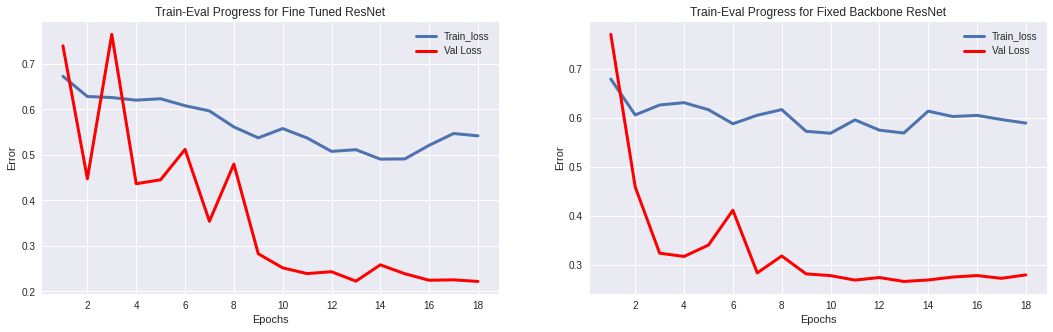

In [27]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[1].plot(stats_resnet_no_cutmix_epoch18['epoch'], stats_resnet_no_cutmix_epoch18['train_loss'], label="Train_loss", linewidth=3)
ax[1].plot(stats_resnet_no_cutmix_epoch18['epoch'], stats_resnet_no_cutmix_epoch18['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Train-Eval Progress for Fixed Backbone ResNet")
plt.show()

## ResNet with SVM classifier

Here in this task we need to extrat features with ResNet and then train SVM on top of these features.